This notebook trains and evaluates predicitive models for hospital readmission within 30 days.
Models implemented include logisitic regression and random forest classifier. 
The target variable is readmitted_30

In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/diabetic_data_clean.csv")
df.shape

(101766, 46)

In [2]:
X = df.drop(columns=["readmitted_30", "readmitted"])
y = df["readmitted_30"]

In [3]:
!pip install scikit-learn 

Train-test spilt 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

Preprocessing pipeline 

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = X_train.select_dtypes(include="object").columns
numeric_cols = X_train.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=3000,      # or 5000
        class_weight="balanced",
        n_jobs=-1           # use all cores if available
    ))
])

Logistic Regression model- a baseline due for nterpretability and efficiency.
Class imbalance is addressed using "class_weight="balanced"

In [7]:
log_reg

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
log_reg.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     18083
           1       0.17      0.55      0.26      2271

    accuracy                           0.64     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.64      0.71     20354

ROC-AUC: 0.6416037765873993


Random Forest model- to capture nonlinear relationships. 

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        class_weight="balanced",   # handle class imbalance
        n_jobs=-1,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)
rf_clf

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Model Evaluation -performance is compared against logistic regression using ROC-AUC and recall.

In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.62      0.01      0.03      2271

    accuracy                           0.89     20354
   macro avg       0.76      0.51      0.48     20354
weighted avg       0.86      0.89      0.84     20354

ROC-AUC: 0.6622781984329658


## Model Comparison Summary

The random forest model has a slightly higher ROC-AUC than logistic regression,
but shows low recall for the readmitted group (1).
Logistic regression provides more balanced recall and interpretability,
making it a stronger baseline for this.

In [12]:
import joblib

joblib.dump(log_reg, "../models/logistic_regression.pkl")

['../models/logistic_regression.pkl']

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance


In [14]:
preprocess = log_reg.named_steps["preprocess"]
model = log_reg.named_steps["model"]

In [15]:
feature_names = preprocess.get_feature_names_out()
len(feature_names), feature_names[:10]

(2281,
 array(['cat__race_?', 'cat__race_AfricanAmerican', 'cat__race_Asian',
        'cat__race_Caucasian', 'cat__race_Hispanic', 'cat__race_Other',
        'cat__gender_Female', 'cat__gender_Male',
        'cat__gender_Unknown/Invalid', 'cat__age_[0-10)'], dtype=object))

In [16]:
import pandas as pd
import numpy as np

coefs = model.coef_.ravel()

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

feat_imp.head(15)

,feature,coef,abs_coef
1230,cat__diag_2_807,-2.264491,2.264491
1774,cat__diag_3_537,-2.072961,2.072961
1537,cat__diag_3_250.91,2.057233,2.057233
458,cat__diag_1_643,2.021095,2.021095
460,cat__diag_1_646,2.014289,2.014289
1453,cat__diag_3_156,1.979067,1.979067
1335,cat__diag_2_999,-1.977132,1.977132
723,cat__diag_2_136,1.971046,1.971046
968,cat__diag_2_429,-1.969299,1.969299
1206,cat__diag_2_782,-1.953636,1.953636


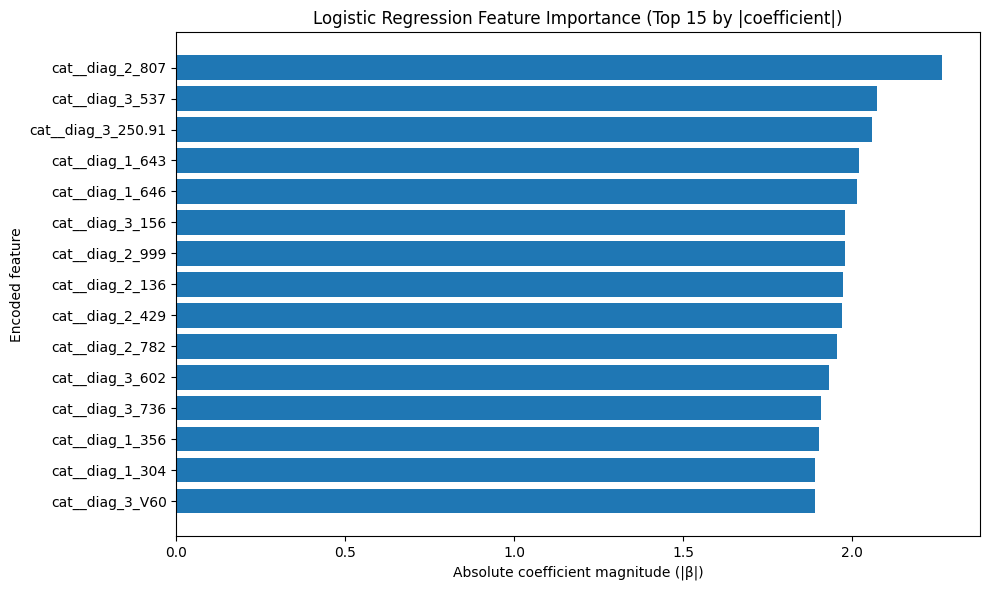

In [17]:
import matplotlib.pyplot as plt

top_n = 15
top = feat_imp.head(top_n).sort_values("abs_coef", ascending=True)  # so it plots nicely

plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["abs_coef"])
plt.title(f"Logistic Regression Feature Importance (Top {top_n} by |coefficient|)")
plt.xlabel("Absolute coefficient magnitude (|β|)")
plt.ylabel("Encoded feature")
plt.tight_layout()
plt.show()